# Benchmark GMM Dorso

### Outline
* generate expression matrix - ground truth (atlas, see normal droso tutorial)
* generate expression matrix - normal reconstruction (see normal droso tutorial)
* generate expression matrix - GMM (see "cleaning demonstration) - maybe different modes

* calculate similarity values of the matrixes
* plot them

Infos:

"dge_rep" mode: None (there are different possibilities, maybe try other later)


In [91]:
# install
# pip install novosparc
# imports
from importlib import reload

import anndata
%matplotlib inline
import novosparc
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
# import altair as alt
from scipy.spatial.distance import cdist, squareform, pdist
from scipy.stats import ks_2samp
from scipy.stats import pearsonr

import random
random.seed(42)

# working directory
# os.chdir("/home/vfs/PycharmProjects/rajewskyLab/novosparc") # when I use this the notebook does not use the normal novosparc anymore - but when I put the notebooke physically in that directory everything works normally - where does this come from?

# test genes
pl_genes = ['sna', 'ken', 'eve','zen2','ush','ImpE2','Adgf-A']

# Reading expression data to scanpy AnnData (cells x genes)
data_dir = 'novosparc/datasets/drosophila_scRNAseq/'
data_path = os.path.join(data_dir, 'dge_normalized.txt')
dataset = sc.read(data_path).T
gene_names = dataset.var.index.tolist()

num_cells, num_genes = dataset.shape # 1297 cells x 8924 genes

print('number of cells: %d' % num_cells)
print('number of genes: %d' % num_genes)
# optional: subset cells
num_cells = 1000
sc.pp.subsample(dataset, n_obs=num_cells)
# dge_rep mode
dge_rep = None # a representation of cells gene expression
# highly var genes
sc.pp.highly_variable_genes(dataset)
is_var_gene = dataset.var['highly_variable']
var_genes = list(is_var_gene.index[is_var_gene])

# atlas settings
atlas_dir = 'novosparc/datasets/bdtnp/'
target_space_path = os.path.join(atlas_dir, 'geometry.txt')
locations = pd.read_csv(target_space_path, sep=' ')
num_locations = 3039 # coming from the spatial data
locations_apriori = locations[:num_locations][['xcoord', 'zcoord']].values

number of cells: 1297
number of genes: 8924


In [ ]:
## Expression Matrix - ground truth
locations = locations_apriori
atlas_path = os.path.join(atlas_dir, 'dge.txt')
atlas = sc.read(atlas_path)
atlas_genes = atlas.var.index.tolist()
atlas.obsm['spatial'] = locations

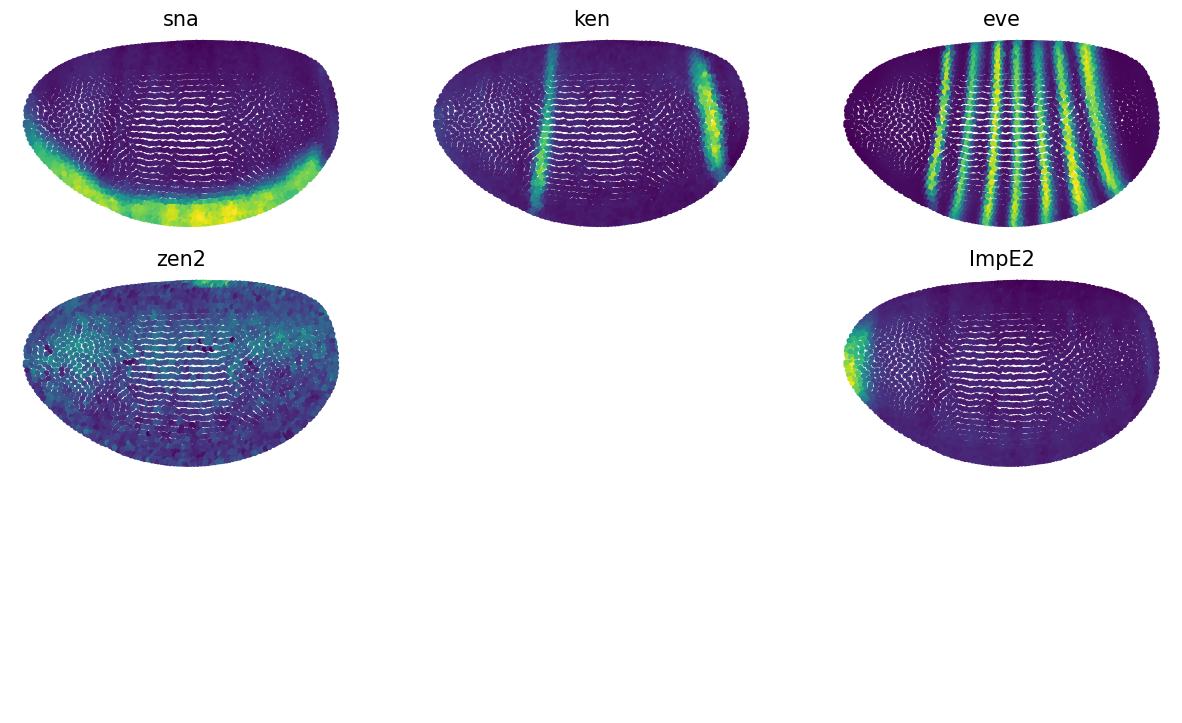

<Figure size 432x288 with 0 Axes>

In [104]:
# test
novosparc.pl.embedding(atlas, pl_genes)

In [93]:
expmtrx_truth = atlas.X

# min-max normalization
expmtrx_truth_normed = (expmtrx_truth - np.min(expmtrx_truth))/ (np.max(expmtrx_truth) - np.min(expmtrx_truth))
expmtrx_truth_normed.shape

(3039, 84)

 ## Expression Matrix - basic reconstruction

In [ ]:
# calculate cost matrix
# params for smooth cost
num_neighbors_s = num_neighbors_t = 5

# params for linear cost
markers = list(set(atlas_genes).intersection(gene_names))
atlas_matrix = atlas.to_df()[markers].values
markers_idx = pd.DataFrame({'markers_idx': np.arange(num_genes)}, index=gene_names)
markers_to_use = np.concatenate(markers_idx.loc[markers].values)

# construct tissue object
tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations_apriori)


tissue.setup_reconstruction(atlas_matrix=atlas_matrix,
                            markers_to_use=markers_to_use,
                            num_neighbors_s=num_neighbors_s,
                            num_neighbors_t=num_neighbors_t)

# dge_rep = None
tissue.setup_smooth_costs(dge_rep=dge_rep, num_neighbors_s=num_neighbors_s, num_neighbors_t=num_neighbors_t)

# compute optimal transport of cells to locations
alpha_linear = 0.8
epsilon = 5e-3
# tissue.dge = sparse.csr_matrix(tissue.dge)
tissue.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon)

# reconstructed expression of individual genes
sdge = tissue.sdge
dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
dataset_reconst.obsm['spatial'] = locations_apriori

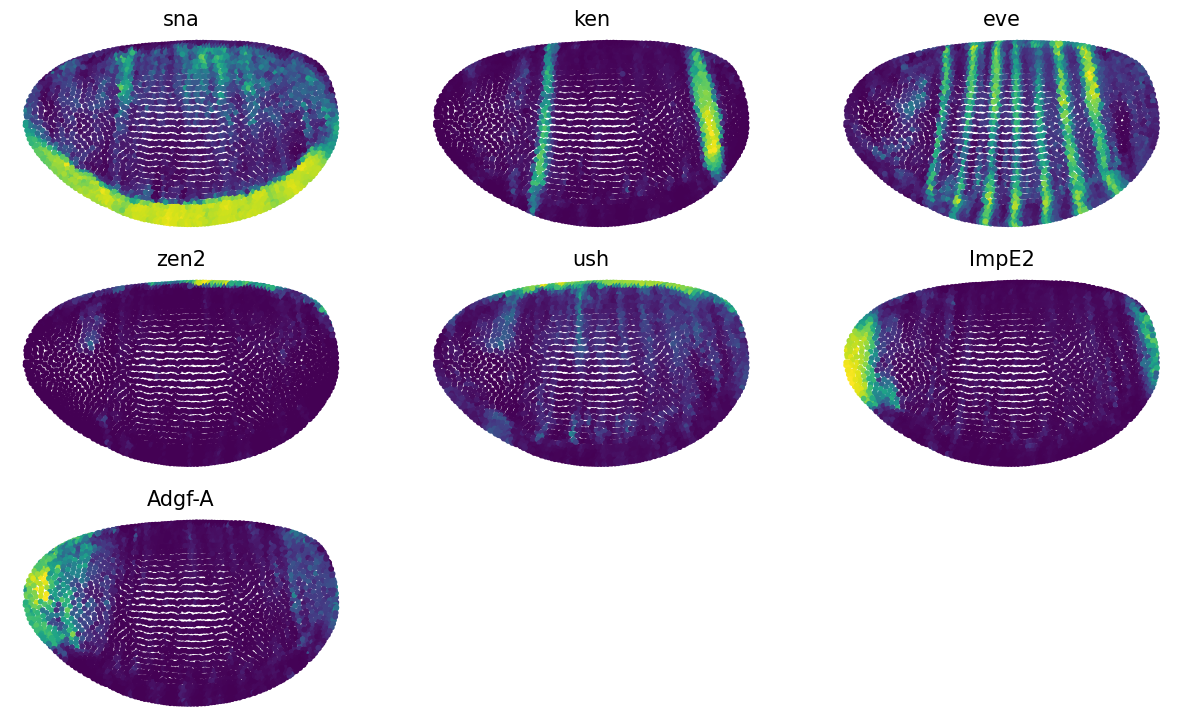

<Figure size 432x288 with 0 Axes>

In [105]:

# test
novosparc.pl.embedding(dataset_reconst, pl_genes)

In [95]:
subset_cols = []
for i, gene in enumerate(atlas_genes):
    if gene in dataset_reconst.var_names:
        subset_cols.append(np.asarray(dataset_reconst[:, gene].X).reshape(-1, 1))
exprmtrx_simplerecon = np.concatenate(subset_cols, axis=1)

# min-max normalization
exprmtrx_simplerecon_normed = (exprmtrx_simplerecon - np.min(exprmtrx_simplerecon))/ (np.max(exprmtrx_simplerecon) - np.min(exprmtrx_simplerecon))
exprmtrx_simplerecon_normed.shape

(3039, 84)

In [96]:
type(atlas_genes)

list

## Expression Matrix - basic cleaning

ToDo: I should think about how to do this in a function so I can do this for multiple settings. Outputting a list of expression matrixes, which I then can use for all the calculations and stuff

In [97]:
# construct tissue object
tissue_postcleaned = novosparc.cm.Tissue(dataset=dataset, locations=locations_apriori)

# alternative 1: setup both assumptions
tissue_postcleaned.setup_reconstruction(atlas_matrix=atlas_matrix,
                            markers_to_use=markers_to_use,
                            num_neighbors_s=num_neighbors_s,
                            num_neighbors_t=num_neighbors_t)

tissue_postcleaned.setup_smooth_costs(dge_rep=dge_rep, num_neighbors_s=num_neighbors_s, num_neighbors_t=num_neighbors_t)

# compute optimal transport of cells to locations
alpha_linear = 0.8
epsilon = 5e-3
# tissue.dge = sparse.csr_matrix(tissue.dge)
tissue_postcleaned.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon)

# reconstructed expression of individual genes
sdge = tissue_postcleaned.sdge

dataset_reconst_postcleaned = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
dataset_reconst_postcleaned.obsm['spatial'] = locations_apriori
# GMM
tissue_postcleaned.cleaning_expression_data(dataset_reconst_postcleaned,tissue_postcleaned.sdge.T,normalization='zscore', selected_genes=atlas_genes)

# reconstructed expression of individual genes
sdge_postcleaned = tissue_postcleaned.cleaned_dge
dataset_reconst_postcleaned = sc.AnnData(pd.DataFrame(sdge_postcleaned, columns=gene_names))
dataset_reconst_postcleaned.obsm['spatial'] = locations_apriori

Setting up for reconstruction ... done ( 4.07 seconds )
Setting up for reconstruction ... done ( 4.11 seconds )
Reconstructing spatial information with 84 markers: 1000 cells and 3039 locations ... 
Trying with epsilon: 5.00e-03
Trying with epsilon: 5.00e-03


/tmp/ipykernel_137096/2647430811.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  dataset_reconst_postcleaned = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not conver

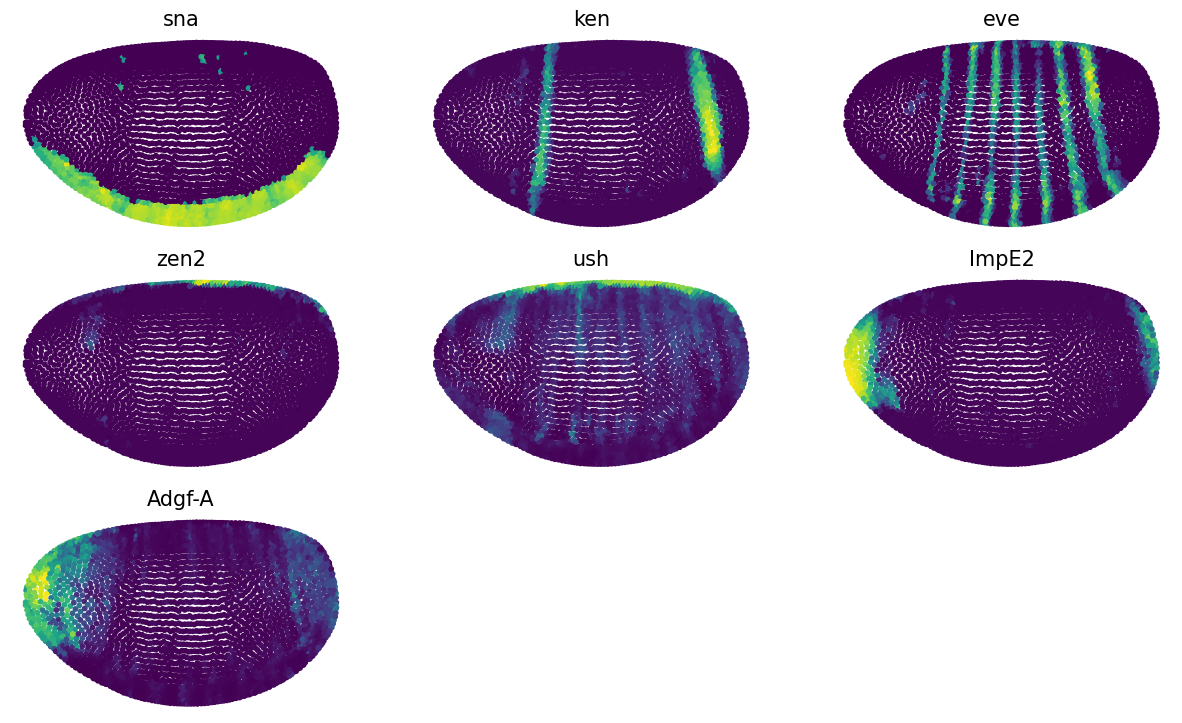

<Figure size 432x288 with 0 Axes>

In [106]:
# test
novosparc.pl.embedding(dataset_reconst_postcleaned, pl_genes)

In [99]:
subset_cols = []
for i, gene in enumerate(atlas_genes):
    if gene in dataset_reconst_postcleaned.var_names:
        subset_cols.append(np.asarray(dataset_reconst_postcleaned[:, gene].X).reshape(-1, 1))
exprmtrx_recon_defaultGMM = np.concatenate(subset_cols, axis=1)

In [100]:
# min-max normalization
exprmtrx_recon_defaultGMM_normed = (exprmtrx_recon_defaultGMM - np.min(exprmtrx_recon_defaultGMM))/ (np.max(exprmtrx_recon_defaultGMM) - np.min(exprmtrx_recon_defaultGMM))
exprmtrx_recon_defaultGMM_normed.shape

(3039, 84)

## Comparing results
ToDo: also make this a function you can loop though just plotting the results in the end

In [101]:
def mse(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.square(np.subtract(actual,pred)).mean()

def rmse(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.sqrt(np.square(np.subtract(actual,pred)).mean())

In [102]:
print("mse: true-recon", mse(expmtrx_truth_normed,exprmtrx_simplerecon_normed))
print("mse: true-cleaned", mse(expmtrx_truth_normed,exprmtrx_recon_defaultGMM_normed))
print("rmse: true-recon", rmse(expmtrx_truth_normed,exprmtrx_simplerecon_normed))
print("rmse: true-cleaned", rmse(expmtrx_truth_normed,exprmtrx_recon_defaultGMM_normed))

mse: true-recon 0.039253302
mse: true-cleaned 0.023134518
rmse: true-recon 0.19812445
rmse: true-cleaned 0.15210035


In [103]:
for x in range(10):
    print(x)
    if x > 3:
        break
else:
    print("a")

0
1
2
3
4
